# Sentiment analysis using 1-D CNN

## Data Loading and Preprocessing

The dataset used for this notebook can be found here- http://ai.stanford.edu/~amaas/data/sentiment/

In [66]:
from pathlib import Path
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import re
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

[nltk_data] Downloading package punkt to /home/shikhar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH = Path('data/movie/aclImdb/')

In [3]:
list(PATH.iterdir())

[PosixPath('data/movie/aclImdb/glove.6B.200d.txt'),
 PosixPath('data/movie/aclImdb/imdb.vocab'),
 PosixPath('data/movie/aclImdb/test'),
 PosixPath('data/movie/aclImdb/glove.6B.50d.txt'),
 PosixPath('data/movie/aclImdb/glove.6B.300d.txt'),
 PosixPath('data/movie/aclImdb/glove.6B.100d.txt'),
 PosixPath('data/movie/aclImdb/glove.6B.zip'),
 PosixPath('data/movie/aclImdb/imdbEr.txt'),
 PosixPath('data/movie/aclImdb/train'),
 PosixPath('data/movie/aclImdb/README')]

In [4]:
pos_train = list(Path((PATH / 'train/pos')).iterdir())
neg_train = list(Path((PATH / 'train/neg')).iterdir())
pos_test = list(Path((PATH / 'test/pos')).iterdir())
neg_test = list(Path((PATH / 'test/neg')).iterdir())

In [5]:
def read_files(file_list, train_label=None):
    labels = []
    content = []
    for fn in file_list:
        with open(fn) as f:
            content.append(f.readlines())
        labels.append(train_label)
    return content, labels

In [6]:
train1, label1 = read_files(pos_train, 1)
train0, label0 = read_files(neg_train, 0)

In [7]:
test1, test_label1 = read_files(pos_test, 1)
test0, test_label0 = read_files(neg_test, 0)

In [8]:
len(train1), len(train0), label1[0:5], label0[0:5]

(12500, 12500, [1, 1, 1, 1, 1], [0, 0, 0, 0, 0])

In [9]:
len(test1), len(test0), test_label1[0:5], test_label0[0:5]

(12500, 12500, [1, 1, 1, 1, 1], [0, 0, 0, 0, 0])

In [12]:
train1[0][0]

"I would highly recommend this movie! And I certainly shall be personally recommending it to my friends and family here and abroad! It was with excited anticipation, that I have just pre-ordered it online, I enjoyed it so much! It is not out until February/March 2008, but it will be well worth the wait! But first go and see it in the cinema if you can. There is nothing quite like the Cinema-Experience of a cinema-made movie! Insist that your local cinema puts it on! I went to see 'Seachd, the Inaccessible Pinacle' tonight, down here in London, and was really impressed. It is a marvel: a truly beautiful film set in the Scottish Highlands: you will laugh, you will cry, you will be moved in may different ways, you will be intrigued, and as the story within the stories is revealed, you will be amazed at that revelation.<br /><br />This movie is in Scottish Gaelic with English Subtitles, but do not let that detract you if you are not a speaker of the Gaelic: I am just starting, and my son d

In [13]:
# this is from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
def clean_str(string):
    """Tokenization/string cleaning. """
    string = string.lower()
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    string = rem_breaks(string)
    string = string.strip().lower()
    string = word_tokenize(string)
    return string


rm_break = re.compile(r'<\s*br*\s*/?>', re.IGNORECASE)


def rem_breaks(x):
    return rm_break.sub('\n', x)

In [14]:
train0_tok = np.array([clean_str(line[0].strip()) for line in train0])
train1_tok = np.array([clean_str(line[0].strip()) for line in train1])

X = pd.concat(
    [pd.Series(train0_tok), pd.Series(train1_tok)],
    axis=0).reset_index(drop=True)
y = pd.concat(
    [pd.Series(label0), pd.Series(label1)], axis=0).reset_index(drop=True)

In [15]:
test0_tok = np.array([clean_str(line[0].strip()) for line in test0])
test1_tok = np.array([clean_str(line[0].strip()) for line in test1])

X_test = pd.concat([pd.Series(test0_tok), pd.Series(test1_tok)], axis = 0).reset_index(drop = True)
y_test = pd.concat([pd.Series(test_label0), pd.Series(test_label1)], axis = 0).reset_index(drop=True)

# X_test.head(), X_test.tail(), y_test[0:2], y_test[24998:25000]

In [16]:
def get_vocab(list_of_content):
    """Computes Dict of counts of words.
    
    Computes the number of times a word is on a document.
    """
    vocab = defaultdict(float)
    for line in list_of_content:
        words = set([word for word in line])
        for word in words:
            vocab[word] += 1
    return vocab

In [17]:
# getting vocab from training sets
data_vocab = get_vocab(X)

## Embedding Layer

### Initializing embedding layer with Glove embeddings

To get glove pre-trained embeddings:
    `wget http://nlp.stanford.edu/data/glove.6B.zip`

In this section I am keeping the whole Glove embeddings. You can decide to keep just the words on your training set.

We would like to initialize the embeddings from our model with the pre-trained Glove embeddings. After initializing we should "freeze" the embeddings at least initially. The rationale is that we first want the network to learn weights for the other parameters that were randomly initialize. After that phase we could finetune the embeddings to our task. 

`embed.weight.requires_grad = False` freezes the embedding parameters.

The following code initializes the embedding. Here `V` is the vocabulary size and `D` is the embedding size. `pretrained_weight` is a numpy matrix of shape `(V, D)`.

In [18]:
def loadGloveModel(gloveFile="data/movie/aclImdb/glove.6B.50d.txt"):
    """ Loads word vectors into a dictionary."""
    f = open(gloveFile, 'r')
    word_vecs = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        word_vecs[word] = np.array([float(val) for val in splitLine[1:]])
    return word_vecs

In [19]:
word_vecs = loadGloveModel()

In [20]:
def delete_rare_words(word_vecs, data_vocab, min_df=2):
    """ Deletes rare words from data_vocab
    
    Deletes words from data_vocab if they are not in word_vecs
    and don't have at least min_df occurrencies in data_vocab.
    """
    words_delete = []
    for word in data_vocab:
        if data_vocab[word] < min_df and word not in word_vecs:
            words_delete.append(word)
    for word in words_delete:
        data_vocab.pop(word)
    return data_vocab

In [21]:
# clean up issues here
data_vocab = delete_rare_words(word_vecs, data_vocab, min_df=2) 

In [22]:
def create_embedding_matrix(word_vecs, data_vocab, min_df=2, D=50):
    """Creates embedding matrix from word vectors. """
    data_vocab = delete_rare_words(word_vecs, data_vocab, min_df)
    V = len(data_vocab.keys()) + 2
    vocab2index = {}
    W = np.zeros((V, D), dtype="float32")
    vocab = ["", "UNK"]
    # adding a vector for padding
    W[0] = np.zeros(D, dtype='float32')
    # adding a vector for rare words 
    W[1] = np.random.uniform(-0.25,0.25,D)
    vocab2index["UNK"] = 1
    i = 2
    for word in data_vocab:
        if word in word_vecs:
            W[i] = word_vecs[word]
            vocab2index[word] = i
            vocab.append(word)
            i += 1
        else:
            W[i] = np.random.uniform(-0.25,0.25,D)
            vocab2index[word] = i
            vocab.append(word)
            i += 1   
    return W, np.array(vocab), vocab2index

In [23]:
pretrained_weight, vocab, vocab2index = create_embedding_matrix(word_vecs, data_vocab)

In [24]:
D = 50
V = len(pretrained_weight)
emb = nn.Embedding(V, D)
emb.weight.data.copy_(torch.from_numpy(pretrained_weight))


 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0320  0.0428  0.2274  ...  -0.1944 -0.0288  0.0525
 0.1249  0.5263 -0.0339  ...  -0.5452  0.3299  0.4364
          ...             ⋱             ...          
-0.4194 -0.5594 -0.9460  ...  -0.0085 -0.9222  0.3925
 0.0834  0.1951 -0.6645  ...   0.5661 -0.5738 -0.2400
-1.0424 -0.7553 -0.6545  ...  -1.2819 -0.4423 -0.4839
[torch.FloatTensor of size 63478x50]

Question: How many parameters do we have in this embedding matrix?

## Encoding training and validation sets

We will be using 1D Convolutional neural networks as our model. CNNs assume a fixed input size so we need to assume a fixed size and truncate or pad the sentences as needed. Let's find a good value to set our sequence length to.

In [25]:
x_len = np.array([len(x) for x in X])

In [26]:
# returns the index of the word or the index of "UNK" otherwise
vocab2index.get("will", vocab2index["UNK"])

811

In [27]:
np.array([vocab2index.get(w, vocab2index["UNK"]) for w in X[0]])

array([ 13, 104,  20,  44, 106,  94, 101,  94,  35,  32,  19,  94,  64,
         4,   4,  44,  99,   2,  24,  32,  52,  48,  51,  71,  54, 106,
        71,  57, 101,   6,  63,  13,  21,  59,  94,  16,  98,  13, 101,
         3,  83,  17,  32,  89,  85,  49,  73,  62,  94,  36,  21,   3,
        83,   5,  92,  22,  44,  52, 106, 101,   4,   4,  39, 101,  70,
        91,  30,  14,  29,  94,  33,  39, 101,  70,  43,  27,  14,  69,
       102,  94,  46,  43, 105,  69,  11,  92,   4,   4,  77,  20,  44,
        56,  61,  45,  21,  53,  10,  25,  23,  26,  16, 110,  95,  87,
        60,   4,   4,  78,   9,  32,  28,  40,  35,  44,  84,  20,  76,
        90,   4,   4,  31,  44,  13,  80,  86,  97,  12,  94,  37,  20,
        44, 107,  94,  79,  41,  95,  44,  50,  96,   4,   4,  33, 104,
        20,  44, 106,  61,  82, 108,  88,  94,  32,  74,  20,  66,  65,
        12,  93,  32,  81,  34,  63,  32,  72,   7,  68,  94,  29,  75,
       101,  47,  18, 100,  38,  67,  42,  94,  15,  44,   8,  1

In [28]:
def encode_sentence(s, N=650):
    enc = np.zeros(N, dtype=np.int32)
    enc1 = np.array([vocab2index.get(w, vocab2index["UNK"]) for w in s])
    l = min(N, len(enc1))
    enc[:l] = enc1[:l]
    return enc

In [29]:
encode_sentence(X[0])

array([ 13, 104,  20,  44, 106,  94, 101,  94,  35,  32,  19,  94,  64,
         4,   4,  44,  99,   2,  24,  32,  52,  48,  51,  71,  54, 106,
        71,  57, 101,   6,  63,  13,  21,  59,  94,  16,  98,  13, 101,
         3,  83,  17,  32,  89,  85,  49,  73,  62,  94,  36,  21,   3,
        83,   5,  92,  22,  44,  52, 106, 101,   4,   4,  39, 101,  70,
        91,  30,  14,  29,  94,  33,  39, 101,  70,  43,  27,  14,  69,
       102,  94,  46,  43, 105,  69,  11,  92,   4,   4,  77,  20,  44,
        56,  61,  45,  21,  53,  10,  25,  23,  26,  16, 110,  95,  87,
        60,   4,   4,  78,   9,  32,  28,  40,  35,  44,  84,  20,  76,
        90,   4,   4,  31,  44,  13,  80,  86,  97,  12,  94,  37,  20,
        44, 107,  94,  79,  41,  95,  44,  50,  96,   4,   4,  33, 104,
        20,  44, 106,  61,  82, 108,  88,  94,  32,  74,  20,  66,  65,
        12,  93,  32,  81,  34,  63,  32,  72,   7,  68,  94,  29,  75,
       101,  47,  18, 100,  38,  67,  42,  94,  15,  44,   8,  1

In [30]:
x_train = np.vstack([encode_sentence(x) for x in X])
x_train.shape

(25000, 650)

In [31]:
x_test = np.vstack([encode_sentence(x) for x in X_test])
x_test.shape

(25000, 650)

In [32]:
del X, X_test

## 1D CNN model for sentence classification

Notation:
* V -- vocabulary size
* D -- embedding size
* N -- MAX Sentence length

Dataloader

In [36]:
import torch
from torch.utils import data


class Dataset(data.Dataset):

    'Characterizes a dataset for PyTorch'

    def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.y)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        review = self.x[index]
        sentiment = self.y[index]
        return review, sentiment

In [41]:
train_reviews = torch.LongTensor(x_train)
train_sentiment = torch.FloatTensor(np.array(y))

train_dataset = Dataset(train_reviews, train_sentiment)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True)

In [42]:
test_reviews = torch.LongTensor(x_test)
test_sentiment = torch.FloatTensor(np.array(y_test))

test_dataset = Dataset(test_reviews, test_sentiment)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True)

Model class

In [43]:
class SentenceCNN(nn.Module):
    def __init__(self, W, D, glove_weights):
        super(SentenceCNN, self).__init__()
        self.glove_weights = glove_weights
        self.embedding = nn.Embedding(W, D, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(self.glove_weights))
        self.embedding.weight.requires_grad = False

        self.conv_3 = nn.Conv1d(in_channels=D, out_channels=50, kernel_size=3)
        self.conv_4 = nn.Conv1d(in_channels=D, out_channels=50, kernel_size=4)
        self.conv_5 = nn.Conv1d(in_channels=D, out_channels=50, kernel_size=5)

        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(150, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)
        x3 = F.relu(self.conv_3(x))
        x4 = F.relu(self.conv_4(x))
        x5 = F.relu(self.conv_5(x))
        x3 = nn.MaxPool1d(kernel_size=588)(x3)
        x4 = nn.MaxPool1d(kernel_size=587)(x4)
        x5 = nn.MaxPool1d(kernel_size=586)(x5)
        out = torch.cat([x3, x4, x5], 2)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        return self.fc(out)

In [45]:
W = len(pretrained_weight)
D = 50
N = 40
model = SentenceCNN(W, D, glove_weights=pretrained_weight)

Training and testing loop

In [51]:
def train_epocs(model, epochs=10, lr=0.01, wd=0.0):
    parameters = filter(
        lambda p: p.requires_grad,
        model.parameters())  # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)

    for i in range(epochs):
        ctr = 0.
        model.train()  # into training mode
        running_loss = 0.0
        for j, data in enumerate(train_loader):
            ctr += 1
            x, y = data
            x = V(x).cuda()
            y = V(y).float().cuda()
            y_hat = model(x)
            loss = F.binary_cross_entropy_with_logits(y_hat, y.unsqueeze(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]
        print("training loss for epoch ", i + 1, ": ",
              running_loss / ctr)  # used to be loss.data[0]
        test_loss(model)

In [52]:
def test_loss(model):
    model.eval()

    running_loss = 0
    total = 0
    correct = 0

    for j, data in enumerate(test_loader):
        x, y = data
        x, y = V(x), V(y).float()
        x = x.cuda()  # put on gpu
        y = y.cuda()
        y_hat = model(x)
        loss_now = F.binary_cross_entropy_with_logits(y_hat, y.unsqueeze(-1))
        y_pred = y_hat > 0
        correct_now = (y_pred.float() == y.unsqueeze(-1)).sum()
        correct += correct_now.data[0]
        total += len(y.float())
        running_loss += loss_now.data[0]

    accuracy = correct / total
    print("validation loss", ": ", running_loss / len(test_loader), 'Accuracy',
          accuracy, '\n')  # j means this many iterations till end

In [98]:
model = SentenceCNN(W, D, glove_weights=pretrained_weight).cuda()

Learning rate finder

In [68]:
def lrfinder(start, end, model, train_loader, epochs=2):
    model_c = deepcopy(model)
    model_c.train()  # into training mode
    lrs = np.linspace(start, end, epochs * len(train_loader))
    parameters = filter(
        lambda p: p.requires_grad,
        model_c.parameters())  # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters, start)
    losses = []
    ctr = 0
    for i in range(epochs):
        for j, data in enumerate(train_loader):
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr + 1
            x, y = data
            x = V(x).cuda()
            y = V(y).float().cuda()
            y_hat = model_c(x)
            loss = F.binary_cross_entropy_with_logits(y_hat, y.unsqueeze(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
    plt.plot(lrs, losses)

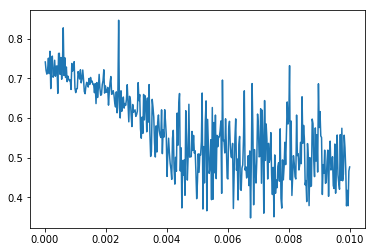

In [71]:
lrfinder(1e-5, 1e-2, model, train_loader, epochs=1)

Going with fixed learning rate of .004

In [99]:
train_epocs(model, epochs=10, lr=0.004)

training loss for epoch  1 :  0.5221643803826989
validation loss :  0.39618929012504683 Accuracy 0.82324 

training loss for epoch  2 :  0.4374901651192809
validation loss :  0.37615701540961594 Accuracy 0.8352 

training loss for epoch  3 :  0.41517072020436796
validation loss :  0.37293083096861535 Accuracy 0.83284 

training loss for epoch  4 :  0.3874170582007874
validation loss :  0.3591991098945403 Accuracy 0.84 

training loss for epoch  5 :  0.379407027150359
validation loss :  0.3758380578835602 Accuracy 0.82908 

training loss for epoch  6 :  0.3682904304064753
validation loss :  0.3565570946087313 Accuracy 0.84268 

training loss for epoch  7 :  0.3556393448958921
validation loss :  0.3617253544385476 Accuracy 0.83732 

training loss for epoch  8 :  0.33845104239023555
validation loss :  0.3649851292219308 Accuracy 0.83964 

training loss for epoch  9 :  0.3355092489353531
validation loss :  0.36516806605221974 Accuracy 0.83596 

training loss for epoch  10 :  0.323633254374

In [100]:
torch.save(model,'data/movie/aclImdb/m1')

/home/shikhar/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type SentenceCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [101]:
m = torch.load('data/movie/aclImdb/m1')

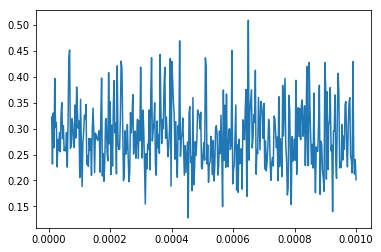

In [102]:
lrfinder(1e-5, 1e-3, m, train_loader, epochs=1)

So we can see that there seems to be no ideal learning rate. So we'll go on and unfreeze the layers

Unfreeze the embeddings for finetuning

In [103]:
model.embedding.weight.requires_grad = True

parameters = filter(lambda p: p.requires_grad, model.parameters())
print([p.size() for p in parameters])

In [108]:
train_loader.batch_size = 1024

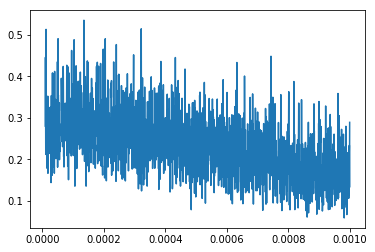

In [110]:
lrfinder(1e-5, 1e-3, model, train_loader, epochs=5)

In [94]:
train_loader.batch_size = 64

In [111]:
train_epocs(model, epochs=3, lr=0.0004)

training loss for epoch  1 :  0.274412384671171
validation loss :  0.32674697152031656 Accuracy 0.85892 

training loss for epoch  2 :  0.23723673803345932
validation loss :  0.3193658227124787 Accuracy 0.86412 

training loss for epoch  3 :  0.20515623585799772
validation loss :  0.316279380865719 Accuracy 0.86712 



In [112]:
torch.save(model,'data/movie/aclImdb/m2')

/home/shikhar/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type SentenceCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [113]:
m = torch.load('data/movie/aclImdb/m2')

In [114]:
train_epocs(m, epochs=3, lr=0.0004)

training loss for epoch  1 :  0.19117375383215487
validation loss :  0.31142320603970675 Accuracy 0.87084 

training loss for epoch  2 :  0.16609368686709564
validation loss :  0.3130367468766239 Accuracy 0.87096 

training loss for epoch  3 :  0.15079255550718673
validation loss :  0.3119653846373034 Accuracy 0.87196 



In [115]:
train_epocs(m, epochs=3, lr=0.0004)

training loss for epoch  1 :  0.13586054856667434
validation loss :  0.3140954465779197 Accuracy 0.87392 

training loss for epoch  2 :  0.12284484616649882
validation loss :  0.3183833338186869 Accuracy 0.8732 

training loss for epoch  3 :  0.1091910782401138
validation loss :  0.3222662996300651 Accuracy 0.87472 



In [116]:
torch.save(m,'data/movie/aclImdb/m3')

/home/shikhar/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type SentenceCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [117]:
m = torch.load('data/movie/aclImdb/m3')

In [120]:
train_loader.batch_size = 2048

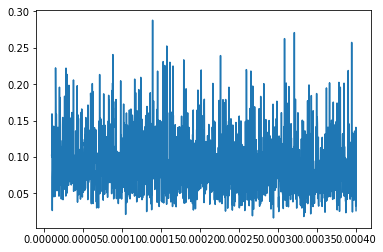

In [122]:
lrfinder(1e-5, 4e-4, m, train_loader, epochs=5)

In [123]:
train_epocs(m, epochs=3, lr=0.0002)

training loss for epoch  1 :  0.09749822328557901
validation loss :  0.3237099426672282 Accuracy 0.87628 

training loss for epoch  2 :  0.09687966457508562
validation loss :  0.32439211891282854 Accuracy 0.87656 

training loss for epoch  3 :  0.08681220739908382
validation loss :  0.32803455082809224 Accuracy 0.87616 



In [124]:
model.embedding.weight.requires_grad = False

parameters = filter(lambda p: p.requires_grad, model.parameters())
print([p.size() for p in parameters])

[torch.Size([50, 50, 3]), torch.Size([50]), torch.Size([50, 50, 4]), torch.Size([50]), torch.Size([50, 50, 5]), torch.Size([50]), torch.Size([1, 150]), torch.Size([1])]


In [125]:
torch.save(m,'data/movie/aclImdb/m4')

/home/shikhar/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type SentenceCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [126]:
m = torch.load('data/movie/aclImdb/m4')

In [127]:
train_loader.batch_size

2048

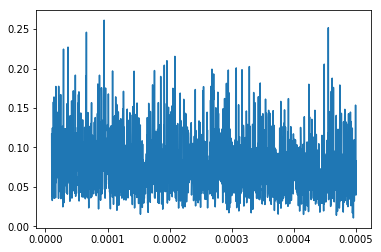

In [129]:
lrfinder(1e-5, 5e-4, m, train_loader, epochs=5)

In [130]:
train_epocs(m, epochs=3, lr=0.00015)

training loss for epoch  1 :  0.08162848428939767
validation loss :  0.3291333240011464 Accuracy 0.87712 

training loss for epoch  2 :  0.07766528004099188
validation loss :  0.33275655001554344 Accuracy 0.87692 

training loss for epoch  3 :  0.07438862727731085
validation loss :  0.3353022568480438 Accuracy 0.87624 



Final validation accuracy: 87%